<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>

Figure 1.1.a. Jupyter environment + Python notebooks

# Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe.

## Step 1.1: Configure the environment

In [1]:
from datetime import datetime
from shapely.geometry import Polygon
from shapely import box
from pyproj import CRS 
import folium
import geopandas as gpd
import numpy as np
import pandas as pd
import rasterio as rio
import xarray as xr
import rioxarray
from ipyleaflet import basemaps
from numpy.lib.stride_tricks import sliding_window_view
import pystac_client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import planetary_computer
from odc.stac import load
from pystac.client import Client
from skimage.feature import graycomatrix, graycoprops
from utils import load_data, scale, do_prediction, calculate_band_indices, apply_masks, elevation_mask, glcm_features

In [2]:
# Predefined variable for title and version

# Enter your initials
initials = "nm"

# Enter your site name
site = "serua"

# Date
date = datetime.now()

# Make a clean version string
version = f"{initials}-{site}-{date.strftime('%d%m%Y')}"
print(version)

nm-serua-14072025


## Step 1.2: Configure STAC access and search parameters

In [3]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [4]:
# ## Use training data bounds

training = gpd.read_file("training-data/nm-serua-14072025_postcard.geojson")
training = training.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = training.total_bounds

bbox = [min_lon, min_lat, max_lon, max_lat]

# TODO: configure colours...
# training.explore(column="observed")

In [5]:
datetime = "2024"

items = client.search(
    collections=["dep_s2_geomad"],
    datetime=datetime,
    bbox=bbox
).item_collection()

print(f"Found {len(items)} items in for {datetime}")

Found 1 items in for 2024


In [6]:
measurements = ["nir", "red", "blue", "green", "emad", "smad", "bcmad", "count", "green", "nir08", "nir09", "swir16", "swir22", "coastal", "rededge1", "rededge2", "rededge3"]
data = load_data(
    items,
    measurements,
    bbox,
)
    
# Now you can use the 'data' variable
print(data)

<xarray.Dataset> Size: 250kB
Dimensions:      (y: 84, x: 78, time: 1)
Coordinates:
  * y            (y) float64 672B -2.054e+06 -2.054e+06 ... -2.055e+06
  * x            (x) float64 624B 3.098e+06 3.098e+06 ... 3.099e+06 3.099e+06
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/16)
    nir          (time, y, x) uint16 13kB dask.array<chunksize=(1, 84, 78), meta=np.ndarray>
    red          (time, y, x) uint16 13kB dask.array<chunksize=(1, 84, 78), meta=np.ndarray>
    blue         (time, y, x) uint16 13kB dask.array<chunksize=(1, 84, 78), meta=np.ndarray>
    green        (time, y, x) uint16 13kB dask.array<chunksize=(1, 84, 78), meta=np.ndarray>
    emad         (time, y, x) float32 26kB dask.array<chunksize=(1, 84, 78), meta=np.ndarray>
    smad         (time, y, x) float32 26kB dask.array<chunksize=(1, 84, 78), meta=np.ndarray>
    ...           ...
    swir16       (time, y, x) uint16 13kB dask.array<chunksize=(1, 84, 78), me

In [7]:
dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
configure_s3_access(cloud_defaults=True, requester_pays=True)

In [8]:
scaled = scale(data)
scaled = scaled.compute().squeeze()

In [9]:
# Explore the site we are working on
scaled.odc.explore(vmin=0, vmax=0.3, bands=["red", "green", "blue"], crs="EPSG:3832", name=site)

In [10]:
scaled

<xarray.Dataset> Size: 761kB
Dimensions:      (y: 84, x: 78)
Coordinates:
  * y            (y) float64 672B -2.054e+06 -2.054e+06 ... -2.055e+06
  * x            (x) float64 624B 3.098e+06 3.098e+06 ... 3.099e+06 3.099e+06
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/16)
    nir          (y, x) float64 52kB 0.0275 0.0286 0.0314 ... 0.0351 0.0364
    red          (y, x) float64 52kB 0.0745 0.0775 0.0802 ... 0.0652 0.0622
    blue         (y, x) float64 52kB 0.1197 0.1243 0.131 ... 0.0891 0.0846
    green        (y, x) float64 52kB 0.1396 0.144 0.1503 ... 0.1024 0.1028 0.098
    emad         (y, x) float32 26kB 0.09624 0.09588 0.09791 ... 0.1079 0.1081
    smad         (y, x) float32 26kB 3.872e-06 3.743e-06 ... 6.157e-06 6.098e-06
    ...           ...
    swir16       (y, x) float64 52kB 0.0216 0.0216 0.0234 ... 0.0298 0.0297
    swir22       (y, x) float64 52kB 0.021 0.021 0.0224 ... 0.0307 0.0296 0.0295
    coastal      (y, x) float64 52kB 0.0973 0.0974 0.0973 ... 0.0713 0.0713
    rededge1     (y, x) float64 52kB 0.0668 0.067 0.0723 ... 0.0676 0.0674
    rededge2     (y, x) float64 52kB 0.0273 0.0273 0.0298 ... 0.0346 0.0346
    rededge3     (y, x) float64 52kB 0.0307 0.0307 0.0322 ... 0.037 0.0369

In [11]:
scaled = calculate_band_indices(scaled)

In [12]:
## Moderate land mask
MNDWI_THRESHOLD = -0.2
mndwi_mask = scaled.mndwi > MNDWI_THRESHOLD

mndwi_mask.odc.explore()

In [13]:
# ln_bg = scaled['ln_bg'].values.flatten()  # flatten in case it's multi-dimensional
ln_bg = scaled['ln_bg'].squeeze()  # flatten in case it's multi-dimensional
# Remove NaNs if present
# ln_bg = ln_bg[~np.isnan(ln_bg)]
# Calculate mean and std
# mean = ln_bg.mean()
# std = ln_bg.std()


(array([  1.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   1.,   1.,
          2.,   1.,   1.,   0.,   1.,   1.,   1.,   2.,   0.,   1.,   0.,
          0.,   3.,   1.,   1.,   0.,   0.,   0.,   1.,   2.,   1.,   0.,
          2.,   0.,   0.,   0.,   0.,   0.,   2.,   2.,   0.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   0.,   2.,   0.,   2.,   0.,   1.,
          2.,   1.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,   1.,   0.,
          0.,   1.,   5.,   4.,   8.,   5.,  11.,  13.,   9.,  14.,  13.,
         19.,  23.,  34.,  53.,  90., 117., 235., 407., 644., 815., 894.,
        852., 739., 629., 403., 245., 151.,  56.,  14.,   5.,   0.,   0.,
          2.]),
 array([-0.68208376, -0.67602505, -0.66996635, -0.66390764, -0.65784894,
        -0.65179023, -0.64573152, -0.63967282, -0.63361411, -0.6275554 ,
        -0.6214967 , -0.61543799, -0.60937928, -0.60332058, -0.59726187,
        -0.59120316, -0.58514446, -0.57908575, -0.57302705, -0.56696834,
        -0.56090963, -0.55

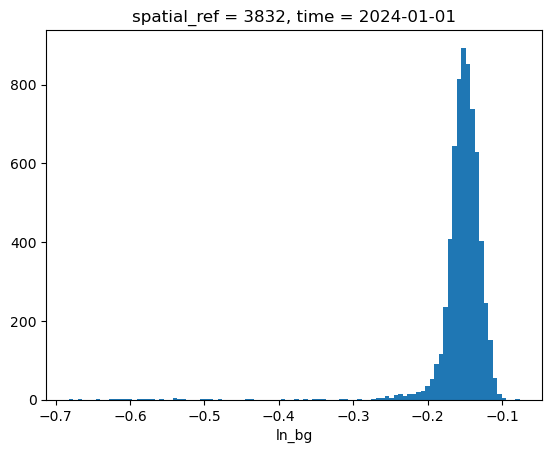

In [14]:
ln_bg.plot.hist(bins=100)

In [15]:
# Deep ocean mask
# ln_bg_mask = scaled["ln_bg"] < -0.08
ln_bg_mask = scaled["ln_bg"] < 0
# ln_bg_mask = scaled["ln_bg"] < -0.2

ln_bg_mask.odc.explore(tiles=basemaps.Esri.WorldImagery)

In [16]:
e84_catalog = "https://earth-search.aws.element84.com/v1/"
e84_client = Client.open(e84_catalog)
collection = "cop-dem-glo-30"

items = e84_client.search(
    collections=[collection],
    bbox=bbox
).item_collection()

items

# Using geobox means it will load the elevation data the same shape as the other data
elevation = load(items, measurements=["data"], geobox=data.odc.geobox).squeeze()

# True where data is above 10m elevation
elevation_mask = elevation.data < 10

# elevation_mask.odc.explore()

In [17]:
# elevation mask is having issues
all_masks = mndwi_mask & ln_bg_mask & elevation_mask
all_masks = all_masks.rio.write_crs("EPSG:3832") # Use .rio.reproject

centroid = scaled.odc.geobox.geographic_extent.centroid.coords[0][::-1]
m = folium.Map(location=centroid, zoom_start=14)

scaled.odc.to_rgba(bands=["red", "green", "blue"], vmin=0, vmax=0.3).odc.add_to(m, name="RGB")
mndwi_mask.where(mndwi_mask == 0).odc.add_to(m, name="MNDWI Mask", vmin=0, vmax=1)
# ndti_mask.where(ndti_mask == 0).odc.add_to(m, name="NDTI Mask", vmin=0, vmax=1)
ln_bg_mask.where(ln_bg_mask == 0).odc.add_to(m, name="ln_bg Mask", vmin=0, vmax=1)
all_masks.where(all_masks == 0).odc.add_to(m, name="All Masks", vmin=0, vmax=1)
# all_masks.odc.add_to(m, name="All Masks", vmin=0, vmax=1) 

folium.LayerControl().add_to(m)

m

In [18]:
# Now apply the mask, and view the masked region

masked = scaled.where(all_masks)
masked.odc.explore(
    vmin=0, vmax=0.3, bands=["red", "green", "blue"], name=f"{site}-masked", tiles=basemaps.Esri.WorldImagery
)

/srv/conda/envs/notebook/lib/python3.10/site-packages/odc/geo/_rgba.py:55: RuntimeWarning: invalid value encountered in cast
  return x.astype("uint8")


### GLCM texture analysis

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [19]:
WINDOW_SIZE = 9
LEVELS = 32

# Input
max = masked.blue.max().values
min = masked.blue.min().values
# Scale to 0-LEVELS for GLCM
img = ((masked.blue - min) / (max - min) * (LEVELS - 1)).clip(0, LEVELS - 1).values.astype(np.uint8)

# Extract overlapping windows
patches = sliding_window_view(img, (WINDOW_SIZE, WINDOW_SIZE))
# Shape: (rows, cols, win_y, win_x)


/tmp/ipykernel_2625/3068184428.py:8: RuntimeWarning: invalid value encountered in cast
  img = ((masked.blue - min) / (max - min) * (LEVELS - 1)).clip(0, LEVELS - 1).values.astype(np.uint8)


In [20]:
import numpy as np # Ensure numpy is imported if not already

# Assuming 'patches' is a 4D NumPy array with dimensions (y_coords, x_coords, window_y_size, window_x_size)
# To get the first patch (at y=0, x=0), you would index it like this:
sample_patch_data = patches[0, 0, :, :]

# Verify the shape of the extracted sample patch data
print(f"Shape of sample_patch_data: {sample_patch_data.shape}")

# Call glcm_features directly on this 2D sample data
sample_result = glcm_features(sample_patch_data)

# Print the shape of the result to get the number of features
print(f"Shape of glcm_features output for a single patch: {sample_result.shape}")

Shape of sample_patch_data: (9, 9)
Shape of glcm_features output for a single patch: (7,)


In [21]:
# Use apply_ufunc to vectorize over (row, col) dimensions
result = xr.apply_ufunc(
    glcm_features,
    xr.DataArray(patches, dims=["y", "x", "win_y", "win_x"]),
    input_core_dims=[["win_y", "win_x"]],
    output_core_dims=[["feature"]],
    vectorize=True,
    dask="parallelized",
    output_dtypes=[np.float32]
)

# Add coordinates & names
pad = WINDOW_SIZE - 1
result = result.assign_coords({
    "y": masked.y[: -pad],
    "x": masked.x[: -pad],
    "feature": ["contrast", "homogeneity", "energy", "ASM", "correlation", "mean", "entropy"]
})

result_bands = result.to_dataset(dim="feature")

# Combine with original
masked_plus = masked.copy()
masked_plus = masked_plus.assign(result_bands)

masked_plus

<xarray.Dataset> Size: 2MB
Dimensions:      (y: 84, x: 78)
Coordinates:
  * y            (y) float64 672B -2.054e+06 -2.054e+06 ... -2.055e+06
  * x            (x) float64 624B 3.098e+06 3.098e+06 ... 3.099e+06 3.099e+06
    time         datetime64[ns] 8B 2024-01-01
Data variables: (12/35)
    nir          (y, x) float64 52kB 0.0275 0.0286 0.0314 ... 0.0351 0.0364
    red          (y, x) float64 52kB 0.0745 0.0775 0.0802 ... 0.0652 0.0622
    blue         (y, x) float64 52kB 0.1197 0.1243 0.131 ... 0.0891 0.0846
    green        (y, x) float64 52kB 0.1396 0.144 0.1503 ... 0.1024 0.1028 0.098
    emad         (y, x) float32 26kB 0.09624 0.09588 0.09791 ... 0.1079 0.1081
    smad         (y, x) float32 26kB 3.872e-06 3.743e-06 ... 6.157e-06 6.098e-06
    ...           ...
    homogeneity  (y, x) float32 26kB 0.6111 0.6361 0.6417 0.6236 ... nan nan nan
    energy       (y, x) float32 26kB 0.2785 0.2755 0.2699 0.272 ... nan nan nan
    ASM          (y, x) float32 26kB 0.07755 0.07591 0.07282 ... nan nan nan
    correlation  (y, x) float32 26kB 0.5818 0.6497 0.64 0.5984 ... nan nan nan
    mean         (y, x) float32 26kB 18.43 18.64 18.85 19.05 ... nan nan nan nan
    entropy      (y, x) float32 26kB 3.953 3.981 3.996 3.925 ... nan nan nan nan

In [22]:
# Re-apply the mask
masked_plus = masked_plus.where(all_masks)

### Postcard csv

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [23]:
# Reproject training data to the GeoMAD CRS and convert to xarray
training_reprojected = training.to_crs(masked_plus.odc.crs)
training_da = training_reprojected.assign(
    x=training_reprojected.geometry.x, y=training_reprojected.geometry.y
).to_xarray()

# Extract training values from the masked dataset
training_values = (
    masked_plus.sel(training_da[["x", "y"]], method="nearest")
    .squeeze()
    .compute()
    .to_pandas()
)
training_values

,nir,red,blue,green,emad,smad,bcmad,count,nir08,nir09,...,homogeneity,energy,ASM,correlation,mean,entropy,y,x,time,spatial_ref
index,,,,,,,,,,,,,,,,,,,,,
0,0.1412,0.1573,0.1374,0.1776,0.263184,0.000005,0.000023,0.0020,0.1332,0.1158,...,0.428287,0.124226,0.015432,0.898170,20.687500,6.266876,-2054025.0,3098525.0,2024-01-01,0
1,0.1412,0.1573,0.1374,0.1776,0.263184,0.000005,0.000023,0.0020,0.1332,0.1158,...,0.506794,0.131395,0.017265,0.954634,20.784721,6.110422,-2054025.0,3098515.0,2024-01-01,0
2,0.1067,0.1438,0.1382,0.1734,0.227629,0.000006,0.000026,0.0023,0.1027,0.1134,...,0.583578,0.173194,0.029996,0.985508,17.326389,5.607067,-2054045.0,3098515.0,2024-01-01,0
3,0.1154,0.1662,0.1609,0.1999,0.260504,0.000005,0.000026,0.0021,0.1122,0.1117,...,0.672222,0.213365,0.045525,0.992108,15.388889,5.035168,-2054055.0,3098505.0,2024-01-01,0
4,0.1160,0.1688,0.1641,0.2024,0.269488,0.000005,0.000028,0.0022,0.1153,0.1242,...,0.668056,0.220041,0.048418,0.991780,15.270833,5.025586,-2054055.0,3098495.0,2024-01-01,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499,0.0921,0.1535,0.1568,0.1912,0.202283,0.000004,0.000027,0.0022,0.0826,0.1209,...,0.661111,0.235702,0.055556,0.989757,13.166667,4.864041,-2054065.0,3098485.0,2024-01-01,0
500,0.1160,0.1688,0.1641,0.2024,0.269488,0.000005,0.000028,0.0022,0.1153,0.1242,...,0.668056,0.220041,0.048418,0.991780,15.270833,5.025586,-2054055.0,3098495.0,2024-01-01,0
501,0.1201,0.1650,0.1560,0.1950,0.251546,0.000005,0.000028,0.0022,0.1088,0.1151,...,0.628023,0.198373,0.039352,0.986844,16.895834,5.391963,-2054045.0,3098495.0,2024-01-01,0


In [24]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([training["cc_id"], training_values], axis=1)

# Drop rows where there was no data available
training_array = training_array.dropna()

# Preview our resulting training array
training_array.head()

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,homogeneity,energy,ASM,correlation,mean,entropy,y,x,time,spatial_ref
0,3,0.1412,0.1573,0.1374,0.1776,0.263184,0.000005,0.000023,0.0020,0.1332,...,0.428287,0.124226,0.015432,0.898170,20.687500,6.266876,-2054025.0,3098525.0,2024-01-01,0
1,3,0.1412,0.1573,0.1374,0.1776,0.263184,0.000005,0.000023,0.0020,0.1332,...,0.506794,0.131395,0.017265,0.954634,20.784721,6.110422,-2054025.0,3098515.0,2024-01-01,0
2,3,0.1067,0.1438,0.1382,0.1734,0.227629,0.000006,0.000026,0.0023,0.1027,...,0.583578,0.173194,0.029996,0.985508,17.326389,5.607067,-2054045.0,3098515.0,2024-01-01,0
3,3,0.1154,0.1662,0.1609,0.1999,0.260504,0.000005,0.000026,0.0021,0.1122,...,0.672222,0.213365,0.045525,0.992108,15.388889,5.035168,-2054055.0,3098505.0,2024-01-01,0
4,3,0.1160,0.1688,0.1641,0.2024,0.269488,0.000005,0.000028,0.0022,0.1153,...,0.668056,0.220041,0.048418,0.991780,15.270833,5.025586,-2054055.0,3098495.0,2024-01-01,0


In [25]:
# Write the training data to a CSV file
training_array.to_csv(f"training-data/{version}-training.csv", index=False)